<a href="https://colab.research.google.com/github/AnshulSingh-eZ/Deep-Learning/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [76]:
class Value():
  def __init__(self, data, _prev=(), _op='' ,label=''):
    self.data = data
    self.grad=0.0
    self._prev = _prev
    self._backward = lambda : None
    self._op=_op
    self.label = label
  def __repr__(self):
    return f"{self.grad} | {self.data} | {self.label}"
  def __add__(self, other):
    out = Value(self.data+other.data, (self, other), "+")
    def _backward():
      self.grad += out.grad * 1.0
      other.grad += out.grad * 1.0
    out._backward = _backward
    return out
  def __mul__(self, other):
    out = Value(self.data*other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def sigmoid(self):
    sig = 1/(1+math.exp(-1*self.data))
    out = Value(sig, (self,), 'sigmoid')
    def _backward():
      self.grad += sig*(1-sig) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if not v in visited:
        visited.add(v)
      for u in v._prev:
        build_topo(u)
      topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [77]:
a = Value(0.3, label='a')
b = Value(0.4, label='b')
c = a+b
c.label='c'
d = Value(1.0, label='d')
e = c*d
e.label='e'
f = e.sigmoid()
f.label = 'f'

In [8]:
from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

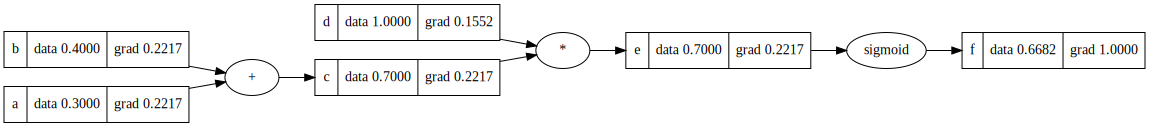

In [80]:
draw_dot(f)

In [79]:
f.backward()